In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import BartForConditionalGeneration, BartTokenizer, Trainer, TrainingArguments
from datasets import Dataset
import torch
import os

train_df = pd.read_csv('/content/train.csv')
val_df = pd.read_csv('/content/valid.csv')
test_df = pd.read_csv('/content/clinicalnlp_taskB_test1.csv')

print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)
print("Test shape:", test_df.shape)


Train shape: (67, 4)
Validation shape: (20, 4)
Test shape: (40, 4)


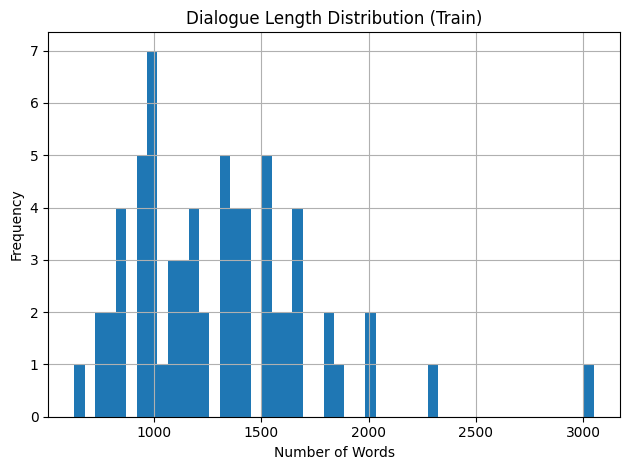

In [3]:
train_df['dialogue_length'] = train_df['dialogue'].apply(lambda x: len(str(x).split()))
train_df['dialogue_length'].hist(bins=50)
plt.title('Dialogue Length Distribution (Train)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


In [4]:
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')
model = BartForConditionalGeneration.from_pretrained('facebook/bart-base')

max_input_length = 1024
max_target_length = 512


In [5]:
# Preprocesare
def preprocess_taskB(examples):
    inputs = examples['dialogue']
    targets = examples['note']

    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True, padding='max_length')
    labels = tokenizer(targets, max_length=max_target_length, truncation=True, padding='max_length')
    model_inputs['labels'] = labels['input_ids']
    return model_inputs

train_dataset = Dataset.from_pandas(train_df[['dialogue', 'note']])
val_dataset = Dataset.from_pandas(val_df[['dialogue', 'note']])

tokenized_train = train_dataset.map(preprocess_taskB, batched=True, remove_columns=train_dataset.column_names)
tokenized_val = val_dataset.map(preprocess_taskB, batched=True, remove_columns=val_dataset.column_names)


Map:   0%|          | 0/67 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

In [7]:
training_args = TrainingArguments(
    output_dir="./mediqa_taskB_bart",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=2,
    logging_steps=100
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
)


/tmp/ipython-input-7-1869846048.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [8]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: morosan-eric2002 (morosan-eric2002-bucharest-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,No log,3.403392
2,No log,3.085042
3,3.718900,2.995144


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3685: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=102, training_loss=3.7205935833500883, metrics={'train_runtime': 3577.674, 'train_samples_per_second': 0.056, 'train_steps_per_second': 0.029, 'total_flos': 122557028106240.0, 'train_loss': 3.7205935833500883, 'epoch': 3.0})

In [9]:
model = model.to("cpu")

test_df["dialogue"] = test_df["dialogue"].astype(str)
test_df = test_df[test_df["dialogue"].str.strip() != ""].reset_index(drop=True)

gen_notes = []
for dialogue in test_df['dialogue']:
    inputs = tokenizer(dialogue, return_tensors='pt', truncation=True, max_length=max_input_length, padding='max_length')
    with torch.no_grad():
        output_ids = model.generate(
            **inputs,
            max_length=max_target_length,
            num_beams=4,
            early_stopping=True
        )
    note = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    gen_notes.append(note)

test_df['predicted_note'] = gen_notes


In [10]:
os.makedirs("output", exist_ok=True)
test_df.to_csv("output/MEDIQA_TaskB_Test_Predictions.csv", index=False)

print("Predicțiile au fost salvate în 'output/MEDIQA_TaskB_Test_Predictions.csv'")


Predicțiile au fost salvate în 'output/MEDIQA_TaskB_Test_Predictions.csv'


In [15]:
%pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=6f08364b4edb78cbac725ecfb3e81a4c9f4f535bd44c860b3a75fddd1f987bad
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [14]:
%pip install evaluate

In [16]:
import pandas as pd
import evaluate

pred_df = pd.read_csv('output/MEDIQA_TaskB_Test_Predictions.csv')
gt_df = pd.read_csv('/content/clinicalnlp_taskB_test1.csv')

assert len(pred_df) == len(gt_df), "Mismatch between prediction and reference sizes."

predictions = pred_df['predicted_note'].astype(str).tolist()
references = gt_df['note'].astype(str).tolist()

rouge = evaluate.load("rouge")
scores = rouge.compute(predictions=predictions, references=references, use_stemmer=True)

print("\n ROUGE scores for Task B (Full Note Generation):\n")
for key, value in scores.items():
    print(f"{key}: {value:.4f}")

analysis_df = pd.DataFrame({
    "Dialogue": gt_df['dialogue'],
    "Ground Truth Note": references,
    "Predicted Note": predictions
})

analysis_df.head(20).to_csv('output/MEDIQA_TaskB_Test_Comparison_Top20.csv', index=False)

print("\nTop 20 examples saved in 'output/MEDIQA_TaskB_Test_Comparison_Top20.csv'.")



📊 ROUGE scores for Task B (Full Note Generation):

rouge1: 0.4530
rouge2: 0.1643
rougeL: 0.1914
rougeLsum: 0.3985

Top 20 examples saved in 'output/MEDIQA_TaskB_Test_Comparison_Top20.csv'.
